## 0. Dependencies

If you have not installed openCV, run the following code

In [ ]:
# ! pip install opencv-python

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Subsetting and Loading

In [1]:
import cv2
import os
import random
import numpy as np

In [2]:
# set a seed
random.seed(328)

# define dir
data_dir = "./crop_part1"
# data_dir = "/content/drive/My Drive/crop_part1"

# random sampling from 9780 samples
n = 1000
fnames_subset = random.sample(os.listdir(data_dir), n)

Construct y

In [3]:
y = [] # 0 (male) or 1 (female)
y_race = []
for fname in fnames_subset:
    temp = fname.split("_")
    y.append(int(temp[1]))
    if temp[2] in ("0", "1"):
        y_race.append(int(temp[2]))
    elif temp[2] in ("2", "3"):
        y_race.append(2)
    else:
        y_race.append(3)
    pass



In [5]:
import pandas as pd
pd.Series(y).unique()

array([1, 0, 3])

Construct X as np arrays

In [4]:
# X: flattened version
# X_origin_dict: original version; key: index, value: 3-D np array
X_rgb = list()
X_origin_dict = dict()
for i, fname in enumerate(fnames_subset):
    # construct dir
    dir = data_dir + "/" + fname
    
    # read the data
    dat = cv2.imread(dir)

    # convert to rgb
    dat = cv2.cvtColor(dat, cv2.COLOR_BGR2RGB)
    
    # store the original data
    X_origin_dict[i] = dat
    
    # store the data
    X_rgb.append(dat)




## 2. Preprocessing

In [7]:
for i, lab in enumerate(y):
    if lab == 3:
        delete = i

y.pop(delete)
y_race.pop(delete)
X_rgb.pop(delete)

array([[[ 45,  45,  47],
        [ 47,  47,  49],
        [ 49,  49,  51],
        ...,
        [ 42,  42,  42],
        [ 42,  42,  42],
        [ 42,  42,  42]],

       [[ 47,  47,  49],
        [ 48,  48,  50],
        [ 49,  49,  51],
        ...,
        [ 42,  42,  42],
        [ 42,  42,  42],
        [ 42,  42,  42]],

       [[ 49,  49,  51],
        [ 49,  49,  51],
        [ 49,  49,  51],
        ...,
        [ 42,  42,  42],
        [ 42,  42,  42],
        [ 42,  42,  42]],

       ...,

       [[229, 160, 103],
        [218, 149,  92],
        [205, 138,  83],
        ...,
        [ 87,  82,  89],
        [ 87,  84,  91],
        [ 88,  85,  92]],

       [[236, 167, 110],
        [227, 158, 101],
        [215, 148,  93],
        ...,
        [ 86,  81,  88],
        [ 86,  83,  90],
        [ 88,  85,  92]],

       [[241, 172, 115],
        [232, 163, 106],
        [221, 154,  99],
        ...,
        [ 85,  80,  87],
        [ 86,  83,  90],
        [ 87,  84,  91]]

In [8]:
# convert to np array
y = np.array(y)
y_race = np.array(y_race)
X_rgb = np.array(X_rgb)
print("The shape of the X_rgb is:", X_rgb.shape)

The shape of the X_rgb is: (9779, 200, 200, 3)


Subsetting for the expriments

In [8]:
import pandas as pd

In [139]:
df = pd.DataFrame({'y': y, 'y_race': y_race, 'img': list(X_rgb)}, columns=['y', 'y_race', 'img'])

In [51]:
df.head()

,y,y_race,img
0,0,3,"[[[150, 121, 107], [150, 121, 107], [149, 120,..."
1,0,3,"[[[210, 203, 197], [228, 221, 215], [245, 238,..."
2,0,3,"[[[31, 27, 16], [30, 26, 15], [29, 25, 14], [2..."
3,1,3,"[[[27, 17, 7], [24, 14, 4], [21, 12, 3], [19, ..."
4,0,3,"[[[16, 16, 16], [17, 17, 17], [18, 18, 18], [1..."


In [109]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    df, y, test_size=0.1, random_state=329
)

X_train_exp, X_val_exp, y_train_exp, y_val_exp = train_test_split(
    X_train_exp, y_train_exp, test_size=(0.1/0.9), random_state=525
)

In [54]:
X_train_exp.head(1)

,y,y_race,img
140,0,3,"[[[42, 42, 42], [34, 34, 34], [29, 29, 29], [3..."


In [68]:
X_train_exp["y_race"].unique()

array([0, 1, 3, 2])

Leave One Out

In [110]:
data_exp_r = {}
for _ in range(4):
    data_exp_r[_] = {}
    data_exp_r[_]["train"] = {}
    data_exp_r[_]["val"] = {}
    data_exp_r[_]["test"] = {}


for r in range(4):
    X_train0 = X_train_exp.loc[(X_train_exp["y_race"] != r)].copy()
    X_train_ex0 = X_train0["img"]
    y_train_ex0 = X_train0["y"]
    X_val0 = X_val_exp.loc[(X_val_exp["y_race"] != r)].copy()
    X_val_ex0 = X_val0["img"]
    y_val_ex0 = X_val0["y"]
    temp = []
    for _ in X_train_ex0:
        temp.append(np.array(_))
    data_exp_r[r]["train"]["X"] = np.array(temp)
    data_exp_r[r]["train"]["y"] = np.array(y_train_ex0)
    temp = []
    for _ in X_val_ex0:
        temp.append(np.array(_))    
    data_exp_r[r]["val"]["X"] = np.array(temp)
    data_exp_r[r]["val"]["y"] = np.array(y_val_ex0)

X_temp, y_temp = [], []
for i in range(4):
    X_test0 = X_test_exp.loc[(X_test_exp["y_race"] == i)].copy()
    X_test_r0 = X_test0["img"]
    y_test_r0 = X_test0["y"]
    temp = []
    for _ in X_test_r0:
        temp.append(np.array(_))  
    X_temp.append(np.array(temp))
    y_temp.append(np.array(y_test_r0))

for r in range(4):
    data_exp_r[r]["test"]["X"] = X_temp
    data_exp_r[r]["test"]["y"] = y_temp


In [109]:
type(data_exp_r[r]["train"]["X"])

numpy.ndarray

80% 20%

In [111]:
data_exp_g = {}

for _ in range(2):
    data_exp_g[_] = {}
    data_exp_g[_]["train"] = {}
    data_exp_g[_]["val"] = {}
    data_exp_g[_]["test"] = {}
  
for g in range(2):
    X_train0 = X_train_exp.loc[(X_train_exp["y"] == g)].copy()

    X_train_ex0 = X_train0["img"]
    y_train_ex0 = X_train0["y"]

    X_train1 = X_train_exp.loc[(X_train_exp["y"] != g)].copy()
    X_train_ex1 = X_train1["img"]
    y_train_ex1 = X_train1["y"]

    target = int(X_train_ex0.shape[0] * 0.25)

    X_slice = X_train_ex1[: target]
    y_slice = y_train_ex1[: target]
    
    X_exp_g = pd.concat([X_train_ex0, X_slice])
    y_exp_g = pd.concat([y_train_ex0, y_slice])
    temp = []
    for _ in X_exp_g:
        temp.append(np.array(_))
    temp = np.array(temp)
    data_exp_g[g]["train"]["X"] = temp
    data_exp_g[g]["train"]["y"] = y_exp_g

    # val
    X_val0 = X_val_exp.loc[(X_val_exp["y"] == g)].copy()
    X_val_ex0 = X_val0["img"]
    y_val_ex0 = X_val0["y"]

    X_val1 = X_val_exp.loc[(X_val_exp["y"] != g)].copy()
    X_val_ex1 = X_val1["img"]
    y_val_ex1 = X_val1["y"]

    target = int(X_val_ex0.shape[0] * 0.25)

    X_slice = X_val_ex1[: target]
    y_slice = y_val_ex1[: target]
    
    X_exp_g = pd.concat([X_val_ex0, X_slice])
    y_exp_g = pd.concat([y_val_ex0, y_slice])

    temp = []
    for _ in X_exp_g:
        temp.append(np.array(_))
    temp = np.array(temp)
    data_exp_g[g]["val"]["X"] = temp
    data_exp_g[g]["val"]["y"] = y_exp_g  

for g in range(2):
    X_temp = X_test_exp["img"]
    y_temp = X_test_exp["y"]
    temp = []
    for _ in X_temp:
        temp.append(np.array(_))
    temp = np.array(temp)
    data_exp_g[g]["test"]["X"] = temp
    data_exp_g[g]["test"]["y"] = np.array(y_temp)


In [126]:
data_exp_g[0]["test"]["X"].shape

(300, 200, 200, 3)

## 3. Modeling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import time
from sklearn.linear_model import LogisticRegression 
import matplotlib
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

In [6]:
X_rgb_train, X_rgb_test, y_train, y_test = train_test_split(
    X_rgb, y, test_size=0.1, random_state=329
)

X_rgb_train, X_rgb_val, y_train, y_val = train_test_split(
    X_rgb_train, y_train, test_size=(0.1/0.9), random_state=525
)


Logistic Regression

In [7]:
X_rgb_flattened_train = np.array([x.flatten() for x in X_rgb_train])
X_rgb_flattened_val = np.array([x.flatten() for x in X_rgb_val])
X_rgb_flattened_test = np.array([x.flatten() for x in X_rgb_test])

In [8]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_rgb_flattened_train)

X_rgb_flattened_train_scaled = X_rgb_flattened_train.copy() 
X_rgb_flattened_train_scaled = scaler.transform(X_rgb_flattened_train)
X_rgb_flattened_val_scaled = scaler.transform(X_rgb_flattened_val)
X_rgb_flattened_test_scaled = scaler.transform(X_rgb_flattened_test)

In [ ]:
# construct a list of C
C = []
temp = -4
step = (4 - (-4)) / (20 - 1) 
while temp <= 4:
    C.append(temp)
    temp += step 
C.pop()
C.append(4)
C_log = copy.deepcopy(C)
C = np.array(C)
C = np.power(10, C)
print("There are {} C values.".format(len(C))) 
print("The C values are:", C)

There are 20 C values.
The C values are: [1.00000000e-04 2.63665090e-04 6.95192796e-04 1.83298071e-03
 4.83293024e-03 1.27427499e-02 3.35981829e-02 8.85866790e-02
 2.33572147e-01 6.15848211e-01 1.62377674e+00 4.28133240e+00
 1.12883789e+01 2.97635144e+01 7.84759970e+01 2.06913808e+02
 5.45559478e+02 1.43844989e+03 3.79269019e+03 1.00000000e+04]


In [ ]:
# init dictionaries for storing results of each interation
num_parameters_l1 = []
auc_l1 = []

# loop through 20 C values
for i, c in enumerate(C):
    model_lr = LogisticRegression(
        penalty="l1", C=c, solver="liblinear", random_state=214
    )

    model_lr.fit(X_rgb_flattened_train_scaled, y_train)

    # counting non-zero parameters
    cnt = 0
    for coef in model_lr.coef_.flatten():
        if coef != 0:
            cnt += 1

    num_parameters_l1.append(cnt)

    # evaluate on val set
    y_val_prob = model_lr.predict_proba(X_rgb_flattened_val_scaled)[:, 1]

    # calculating the auc
    auc_model_lr = metrics.roc_auc_score(y_val, y_val_prob)
    auc_l1.append(auc_model_lr)
    pass

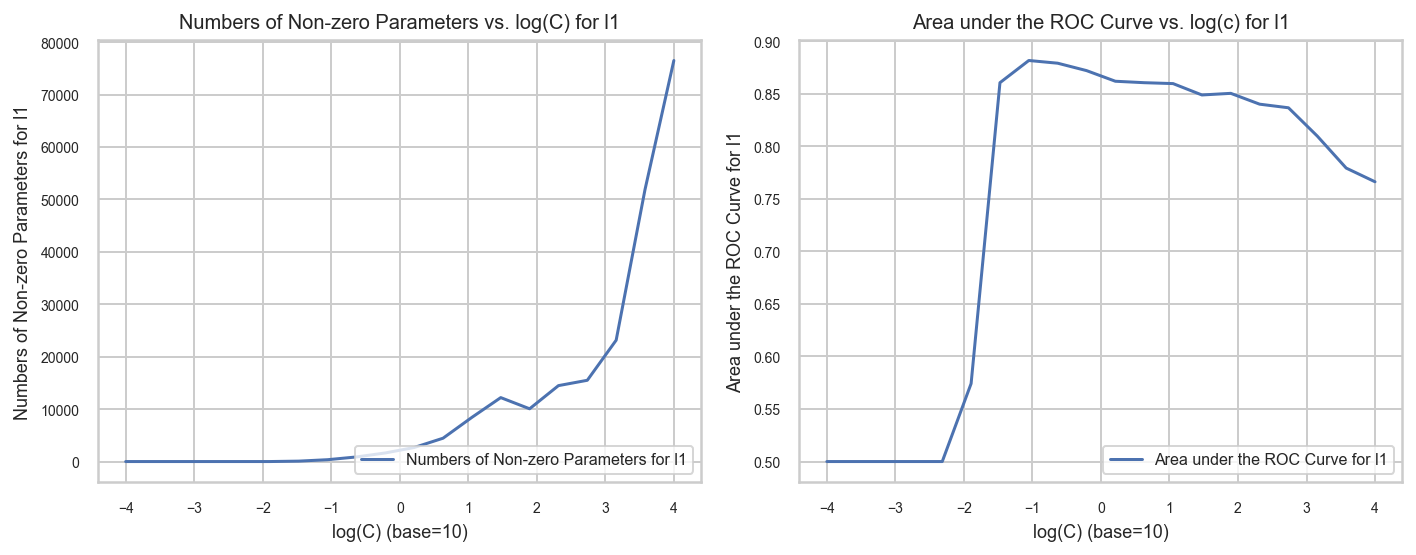

In [ ]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 2*2
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# data for the subplots
dat = [num_parameters_l1, auc_l1]

y_lab = ["Numbers of Non-zero Parameters for l1",
         "Area under the ROC Curve for l1"]

title = [
    "Numbers of Non-zero Parameters vs. log(C) for l1",
    "Area under the ROC Curve vs. log(c) for l1"
]

# make a loop for each plot
for i in range(2):
    axs[i].plot(C_log, dat[i],
                    label=y_lab[i])

    # set the title for each subplot
    axs[i].set_title(
        title[i], fontsize=10
    )

    # set labels
    axs[i].set_xlabel("log(C) (base=10)", fontsize=9)
    axs[i].set_ylabel(y_lab[i], fontsize=9)

    # set ticks
    axs[i].tick_params(labelsize=7)

    # set legends
    legend = axs[i].legend(prop={"size": 8}, loc="lower right")


# use tight layout to save space
plt.tight_layout()

plt.show()

$C=0.0886$ is the optimal choice

In [ ]:
max_auc, ind = 0, 0
for i, auc in enumerate(auc_l1):
    if auc > max_auc:
        max_auc = auc
        ind = i
c_rgb = C[ind]
print("The best C is: {:.4f}".format(c_rgb))

The best C is: 0.0886


In [9]:
model_lr_rgb = LogisticRegression(
    penalty="l1", C=0.0886, solver="liblinear", random_state=214
)

model_lr_rgb.fit(X_rgb_flattened_train_scaled, y_train)

# evaluate on test set
y_test_prob = model_lr_rgb.predict_proba(X_rgb_flattened_test_scaled)[:, 1]

# calculating the auc
auc_model_lr_rgb = metrics.roc_auc_score(y_test, y_test_prob)
print("The AUC is {:.5f}".format(auc_model_lr_rgb))

ap_model_lr_rgb = metrics.average_precision_score(y_test, y_test_prob)
print("The AP is {:.5f}".format(ap_model_lr_rgb))

The AUC is 0.84040
The AP is 0.86018


In [10]:
models = ["Logistic Regression"]
fpr_dict, tpr_dict = dict(), dict()
pc_dict, rc_dict = dict(), dict()
auc_dict, ap_dict = dict(), dict()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob)
pc, rc, thresholds = precision_recall_curve(y_test, y_test_prob)

fpr_dict[models[0]] = fpr
tpr_dict[models[0]] = tpr
pc_dict[models[0]] = pc
rc_dict[models[0]] = rc
auc_dict[models[0]] = auc_model_lr_rgb
ap_dict[models[0]] = ap_model_lr_rgb

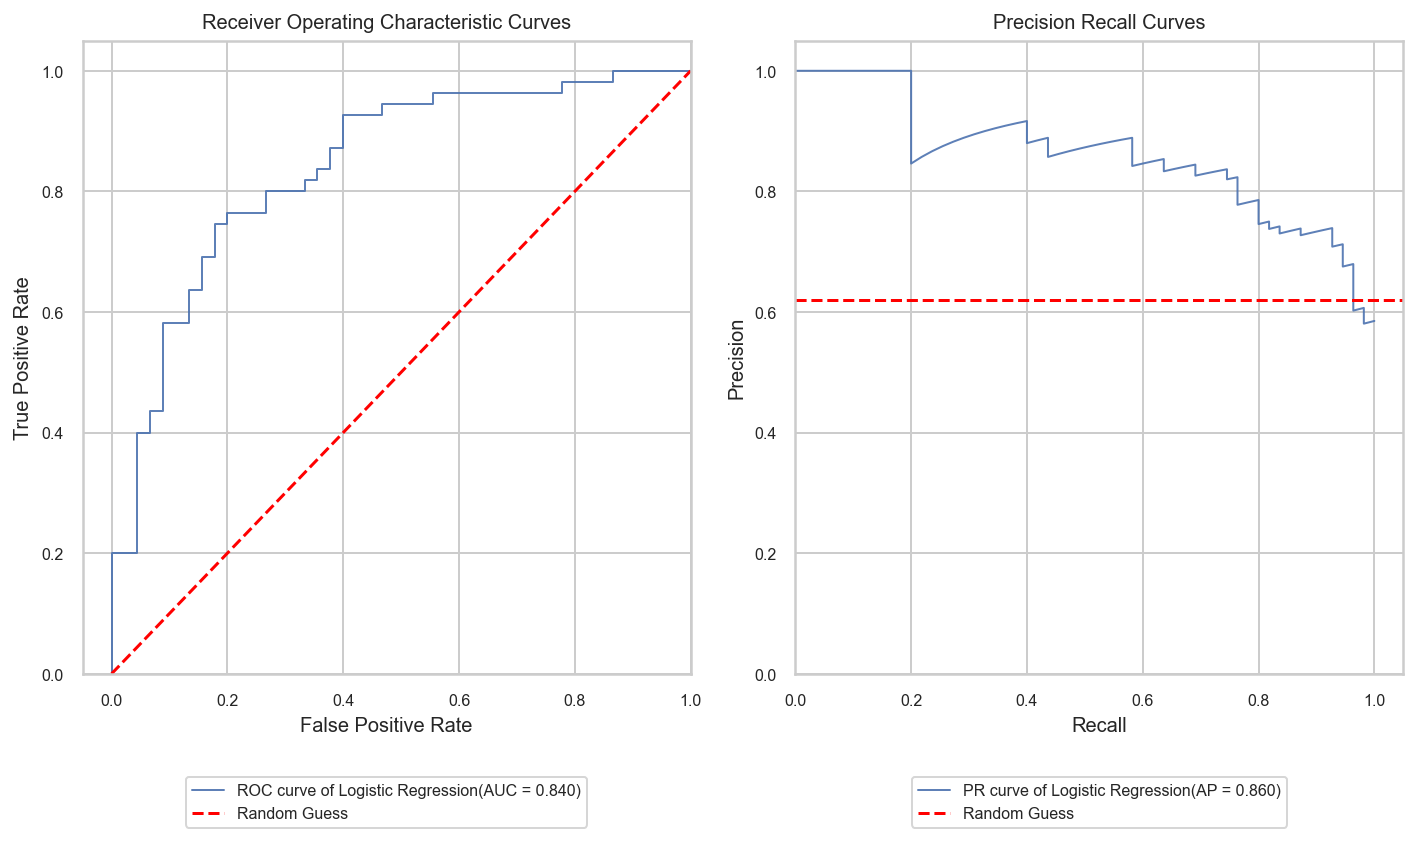

In [11]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 1*2
fig, axs = plt.subplots(1, 2, figsize=(10,6))

# ROC curves
for i in range(len(models)):
    k = models[i]
    axs[0].plot(
          fpr_dict[k],
          tpr_dict[k],
          label="ROC curve of {}(AUC = {:.3f})".format(k, auc_dict[k]),
          lw = 1,
          alpha = 0.9
    )

# PR curves
# reference line
axs[0].plot([0, 1], [0, 1],
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[0].set_title("Receiver Operating Characteristic Curves", fontsize = 10)

axs[0].set_xlabel("False Positive Rate", fontsize = 10)
axs[0].set_ylabel("True Positive Rate", fontsize = 10)

axs[0].set_xlim(-0.05, 1)
axs[0].set_ylim(0, 1.05)

# PR curve for each model
for i in range(len(models)):
    k = models[i]
    axs[1].plot(
            rc_dict[k],
            pc_dict[k],
            label="PR curve of {}(AP = {:.3f})".format(k, ap_dict[k]),
            lw = 1,
            alpha = 0.9
    )


# reference line
axs[1].axhline(y = np.sum(y_val) / len(y_val),
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[1].set_title("Precision Recall Curves", fontsize = 10)

axs[1].set_xlabel("Recall", fontsize = 10)
axs[1].set_ylabel("Precision", fontsize = 10)

axs[1].set_xlim(0, 1.05)
axs[1].set_ylim(0, 1.05)

for j in range(2):
    axs[j].tick_params(labelsize=8)
        
    legend = axs[j].legend(prop={'size': 8},
                           loc="upper center", bbox_to_anchor=(0.5, -0.15))

# use tight layout to save space
plt.tight_layout()

plt.show()

The grey-scale input is tried next.

In [ ]:
X_grey_train = np.array([cv2.cvtColor(dt, cv2.COLOR_BGR2GRAY) for dt in X_rgb_train])
X_grey_val = np.array([cv2.cvtColor(dt, cv2.COLOR_BGR2GRAY) for dt in X_rgb_val])
X_grey_test = np.array([cv2.cvtColor(dt, cv2.COLOR_BGR2GRAY) for dt in X_rgb_test])

In [ ]:
X_grey_flattened_train = np.array([x.flatten() for x in X_grey_train])
X_grey_flattened_val = np.array([x.flatten() for x in X_grey_val])
X_grey_flattened_test = np.array([x.flatten() for x in X_grey_test])

In [ ]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_grey_flattened_train)

X_grey_flattened_train_scaled = X_grey_flattened_train.copy() 
X_grey_flattened_train_scaled = scaler.transform(X_grey_flattened_train)
X_grey_flattened_val_scaled = scaler.transform(X_grey_flattened_val)

In [ ]:
# init dictionaries for storing results of each interation
num_parameters_l1_grey = []
auc_l1_grey = []

# loop through 20 C values
for i, c in enumerate(C):
    model_lr = LogisticRegression(
        penalty="l1", C=c, solver="liblinear", random_state=214
    )

    model_lr.fit(X_grey_flattened_train_scaled, y_train)

    # counting non-zero parameters
    cnt = 0
    for coef in model_lr.coef_.flatten():
        if coef != 0:
            cnt += 1

    num_parameters_l1_grey.append(cnt)

    # evaluate on val set
    y_val_prob = model_lr.predict_proba(X_grey_flattened_val_scaled)[:, 1]

    # calculating the auc
    auc_model_lr = metrics.roc_auc_score(y_val, y_val_prob)
    auc_l1_grey.append(auc_model_lr)
    pass

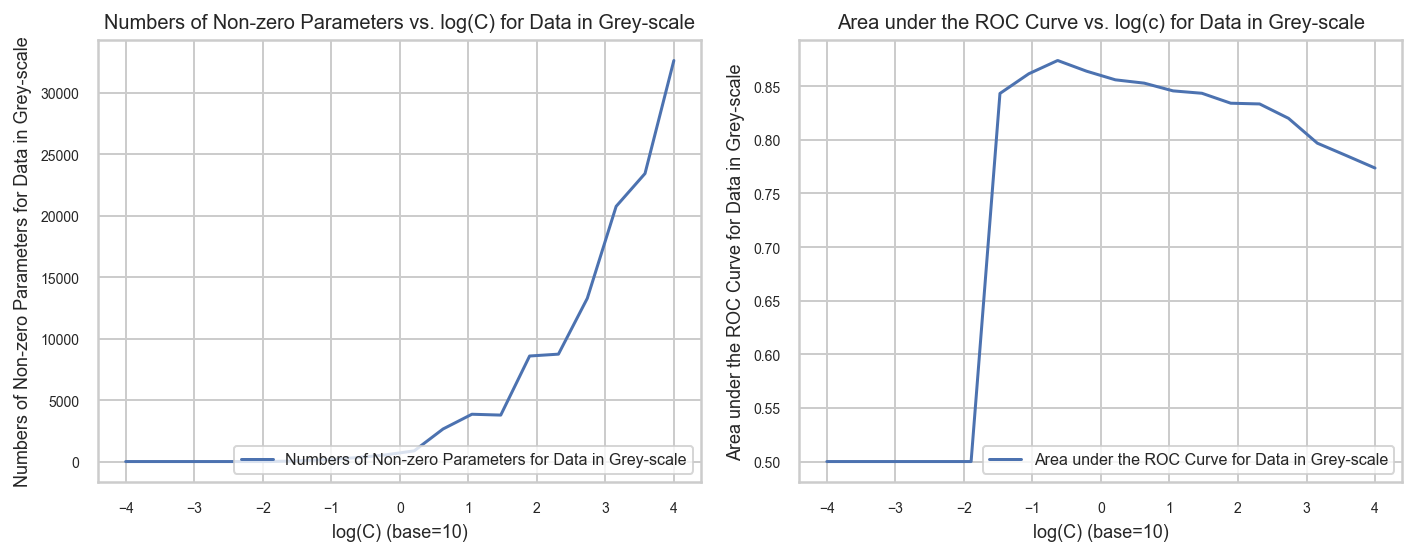

In [ ]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 2*2
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# data for the subplots
dat = [num_parameters_l1_grey, auc_l1_grey]

y_lab = ["Numbers of Non-zero Parameters for Data in Grey-scale",
         "Area under the ROC Curve for Data in Grey-scale"]

title = [
    "Numbers of Non-zero Parameters vs. log(C) for Data in Grey-scale",
    "Area under the ROC Curve vs. log(c) for Data in Grey-scale"
]

# make a loop for each plot
for i in range(2):
    axs[i].plot(C_log, dat[i],
                    label=y_lab[i])

    # set the title for each subplot
    axs[i].set_title(
        title[i], fontsize=10
    )

    # set labels
    axs[i].set_xlabel("log(C) (base=10)", fontsize=9)
    axs[i].set_ylabel(y_lab[i], fontsize=9)

    # set ticks
    axs[i].tick_params(labelsize=7)

    # set legends
    legend = axs[i].legend(prop={"size": 8}, loc="lower right")


# use tight layout to save space
plt.tight_layout()

plt.show()

In [ ]:
max_auc, ind = 0, 0
for i, auc in enumerate(auc_l1_grey):
    if auc > max_auc:
        max_auc = auc
        ind = i
c_grey = C[ind]
print("The best C is: {:.4f}".format(c_grey))

The best C is: 0.2336


In [ ]:
model_lr_rgb = LogisticRegression(
    penalty="l1", C=c_grey, solver="liblinear", random_state=214
)

model_lr_rgb.fit(X_grey_flattened_train_scaled, y_train)

# evaluate on val set
y_val_prob = model_lr_rgb.predict_proba(X_grey_flattened_val_scaled)[:, 1]

# calculating the auc
auc_model_lr_rgb = metrics.roc_auc_score(y_val, y_val_prob)
print("The AUC is {:.5f}".format(auc_model_lr_rgb))

# ap
ap_model_lr_rgb = metrics.roc_auc_score(y_val, y_val_prob)
print("The AUC is {:.5f}".format(auc_model_lr_rgb))

The AUC is 0.87397


The grey-scale input is worse in this case. It may because of some information loss.

Transfer Learning

The workflow and code are learned from the tutorial of transfer learning & fine-tuning in Keras
https://keras.io/guides/transfer_learning/

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Transfer into TSDS

In [ ]:
X_rgb_train.shape

(800, 200, 200, 3)

In [113]:
train_tfds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_rgb_train), tf.convert_to_tensor(y_train)))
val_tfds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_rgb_val), tf.convert_to_tensor(y_val)))
test_tfds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_rgb_test), tf.convert_to_tensor(y_test)))

Prefetch and memory cache to optimize the speed.

In [114]:
train_tfds = train_tfds.cache().batch(32).prefetch(buffer_size=10)
val_tfds = val_tfds.cache().batch(32).prefetch(buffer_size=10)
test_tfds = test_tfds.cache().batch(32).prefetch(buffer_size=10)

Data Augmumentation

In [115]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomFlip("vertical"), layers.RandomRotation(0.1),]
)

Base model

Xception: 
The AUC is 0.90745
The AP is 0.92667

VGG16: The AUC is 0.88301
The AP is 0.90808

ResNet50V2: The AUC is 0.93389
The AP is 0.94022

ResNet101V2: The AUC is 0.95353
The AP is 0.95892

ResNet152V2: The AUC is 0.94511
The AP is 0.94842

InceptionResNetV2: The AUC is 0.90465
The AP is 0.92814

DenseNet121: The AUC is 0.87821
The AP is 0.90430

In [132]:
def buiding_and_tuning_model(train_tfds, val_tfds, dp, epochs_top = 20, epochs_finetuning = 10):
    pretrained_model = keras.applications.ResNet101V2(
        weights="imagenet",
        input_shape=(200, 200, 3),
        include_top=False,
    )

    pretrained_model.trainable = False

    input_tensor = keras.Input(shape=(200, 200, 3))
    x_aug = data_augmentation(input_tensor) 
    scale_layer = keras.layers.Rescaling(scale=(1/(255/2)), offset=-1)
    x_scaled = scale_layer(x_aug)
    x_pretrained = pretrained_model(x_scaled, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x_pretrained)
    x = keras.layers.Dropout(dp)(x)
    out_proba = keras.layers.Dense(1)(x)
    model = keras.Model(input_tensor, out_proba)

    model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
        )

    model.fit(train_tfds, epochs=epochs_top, validation_data=val_tfds)

    pretrained_model.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    model.fit(train_tfds, epochs=epochs_finetuning, validation_data=val_tfds)

    return model

First round, dropout = [0.1, 0.2, 0.3, 0.4, 0.5] were validated. dropout=0.1 was selected since it achieve the best AUC and AP.

Dropout: 0.1
The AUC is 0.95841
The AP is 0.96352

In [ ]:
dropout = [0.001, 0.05, 0.1]
auc, ap = [], []

In [ ]:
for dp in dropout:
    model = buiding_and_tuning_model(dp)

    # evaluate on test set
    y_test_prob = model.predict(X_rgb_test)

    # calculating the auc
    auc_model = metrics.roc_auc_score(y_test, y_test_prob)
    # print("The AUC is {:.5f}".format(auc_model))

    ap_model = metrics.average_precision_score(y_test, y_test_prob)
    # print("The AP is {:.5f}".format(ap_model))

    auc.append(auc_model)
    ap.append(ap_model)

# model.summary()

In [ ]:
ind, max_auc = 0, 0
for i, a in enumerate(auc):
    if max_auc < a:
        max_auc = a
        ind = i
print("Dropout:", dropout[ind])
print("The AUC is {:.5f}".format(auc_model))
print("The AP is {:.5f}".format(ap_model))

ind, max_ap = 0, 0
for i, a in enumerate(ap):
    if max_auc < a:
        max_auc = a
        ind = i
print("Dropout:", dropout[ind])
print("The AUC is {:.5f}".format(auc_model))
print("The AP is {:.5f}".format(ap_model))


Dropout: 0.1
The AUC is 0.95833
The AP is 0.96396
Dropout: 0.1
The AUC is 0.95833
The AP is 0.96396


$dropout=0.1$ is selected

In [83]:
def model_evl(model, X_test, y_test, verbose):
    # evaluate on test set
    y_test_prob = model.predict(X_test)

    # calculating the auc
    auc_model = metrics.roc_auc_score(y_test, y_test_prob)
    if verbose:
        print("The AUC is {:.5f}".format(auc_model))

    ap_model = metrics.average_precision_score(y_test, y_test_prob)
    if verbose:
        print("The AP is {:.5f}".format(ap_model))

    return y_test_prob, auc_model, ap_model

For dropout = 0.1, comparing different models.

In [ ]:
model = buiding_and_tuning_model(train_tfds, val_tfds, 0.1, epochs_top = 20, epochs_finetuning = 10)
y_test_prob, auc, ap = model_evl(model, test_tfds, y_test, True)

In [35]:
from sklearn import metrics

In [38]:
models = ["ResNet101V2"]
fpr_dict, tpr_dict = dict(), dict()
pc_dict, rc_dict = dict(), dict()
auc_dict, ap_dict = dict(), dict()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob)
pc, rc, thresholds = precision_recall_curve(y_test, y_test_prob)

fpr_dict[models[0]] = fpr
tpr_dict[models[0]] = tpr
pc_dict[models[0]] = pc
rc_dict[models[0]] = rc
auc_dict[models[0]] = auc
ap_dict[models[0]] = ap

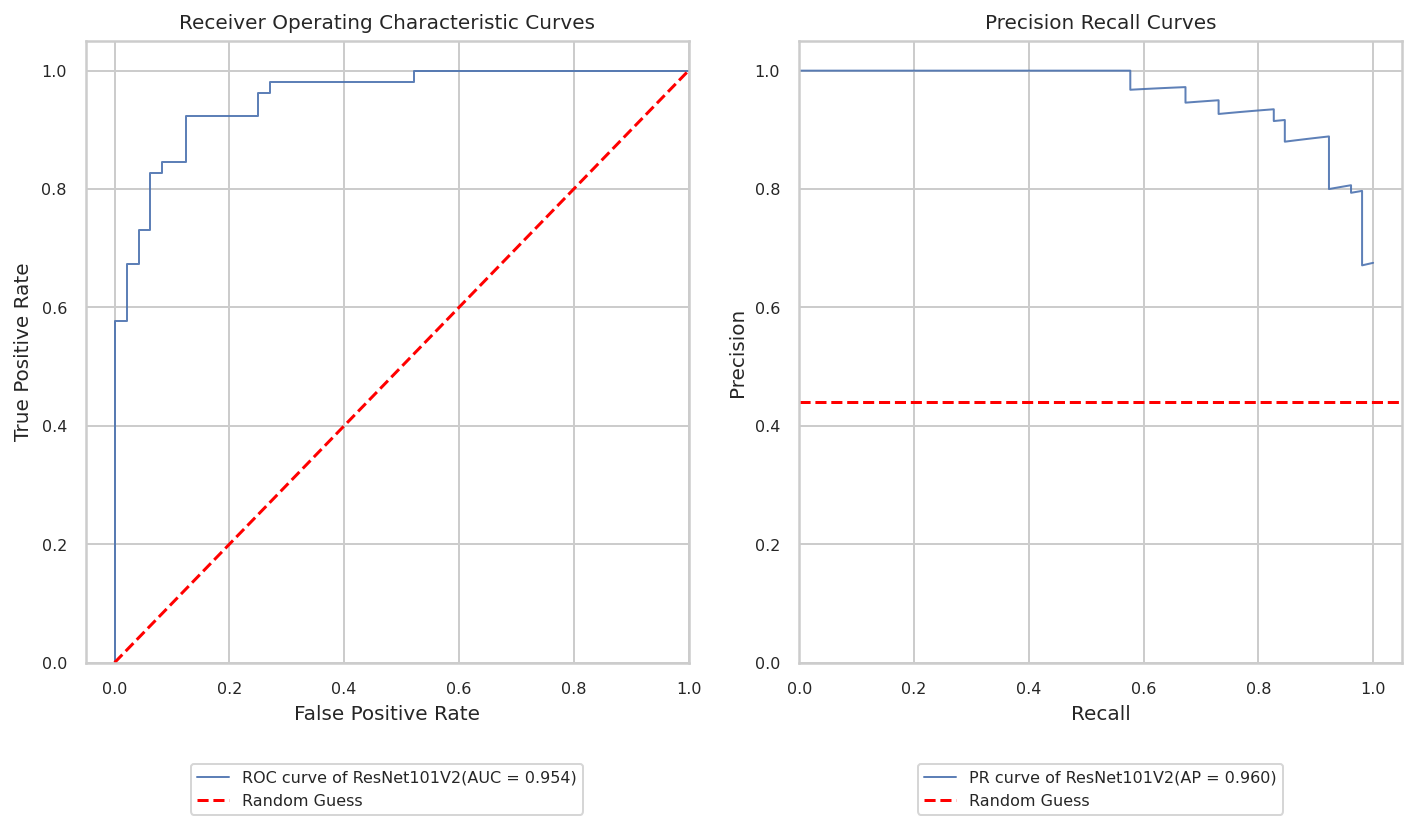

In [39]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 1*2
fig, axs = plt.subplots(1, 2, figsize=(10,6))

# ROC curves
for i in range(len(models)):
    k = models[i]
    axs[0].plot(
          fpr_dict[k],
          tpr_dict[k],
          label="ROC curve of {}(AUC = {:.3f})".format(k, auc_dict[k]),
          lw = 1,
          alpha = 0.9
    )

# PR curves
# reference line
axs[0].plot([0, 1], [0, 1],
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[0].set_title("Receiver Operating Characteristic Curves", fontsize = 10)

axs[0].set_xlabel("False Positive Rate", fontsize = 10)
axs[0].set_ylabel("True Positive Rate", fontsize = 10)

axs[0].set_xlim(-0.05, 1)
axs[0].set_ylim(0, 1.05)

# PR curve for each model
for i in range(len(models)):
    k = models[i]
    axs[1].plot(
            rc_dict[k],
            pc_dict[k],
            label="PR curve of {}(AP = {:.3f})".format(k, ap_dict[k]),
            lw = 1,
            alpha = 0.9
    )


# reference line
axs[1].axhline(y = np.sum(y_val) / len(y_val),
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[1].set_title("Precision Recall Curves", fontsize = 10)

axs[1].set_xlabel("Recall", fontsize = 10)
axs[1].set_ylabel("Precision", fontsize = 10)

axs[1].set_xlim(0, 1.05)
axs[1].set_ylim(0, 1.05)

for j in range(2):
    axs[j].tick_params(labelsize=8)
        
    legend = axs[j].legend(prop={'size': 8},
                           loc="upper center", bbox_to_anchor=(0.5, -0.15))

# use tight layout to save space
plt.tight_layout()

plt.show()

Xception: The AUC is 0.90264
The AP is 0.92228

VGG19: The AUC is 0.90024
The AP is 0.91588

ResNet50V2: The AUC is 0.92909
The AP is 0.93961

ResNet101V2: The AUC is 0.95833
The AP is 0.96396

ResNet152V2: The AUC is 0.94511 The AP is 0.94842

InceptionResNetV2: The AUC is 0.90465 The AP is 0.92814

DenseNet121: The AUC is 0.89263
The AP is 0.91395

DenseNet169: The AUC is 0.93189
The AP is 0.94035

##4. Experiments

In [18]:
def transfer_prefetch(X, y):
    train_tfds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X), tf.convert_to_tensor(y)))
    train_tfds = train_tfds.cache().batch(32).prefetch(buffer_size=10)
    return train_tfds

In [19]:
auc_exp, ap_exp = [], []
for r in range(4):
    X_exp_train = data_exp_r[r]["train"]["X"]    
    y_exp_train = data_exp_r[r]["train"]["y"]

    X_exp_val = data_exp_r[r]["val"]["X"]
    y_exp_val = data_exp_r[r]["val"]["y"]

    X_exp_test = data_exp_r[r]["test"]["X"]
    y_exp_test = data_exp_r[r]["test"]["y"]

    print(X_exp_train.shape)

    
    tfds_exp_train = transfer_prefetch(X_exp_train, y_exp_train)
    tfds_exp_val = transfer_prefetch(X_exp_val, y_exp_val)

    # training
    model = buiding_and_tuning_model(tfds_exp_train, tfds_exp_val, 0.1, epochs_top = 20, epochs_finetuning = 10)

    # evaluation
    auc_temp, ap_temp = [], []
    for t in range(4):
        X_exp_test_sub = X_exp_test[t]
        y_exp_test_sub = y_exp_test[t]
        tfds_exp_test = transfer_prefetch(X_exp_test_sub, y_exp_test_sub)
        y_test_prob, auc, ap = model_evl(model, tfds_exp_test, y_exp_test_sub, True)
        auc_temp.append(auc)
        ap_temp.append(ap)
    auc_exp.append(auc_temp)
    ap_exp.append(ap_temp)



(3594, 200, 200, 3)
171327488/171317808 [==============================] - 3s 0us/step
Epoch 1/20
113/113 [==============================] - 37s 174ms/step - loss: 0.6042 - binary_accuracy: 0.6644 - val_loss: 0.5132 - val_binary_accuracy: 0.7215
Epoch 2/20
113/113 [==============================] - 17s 153ms/step - loss: 0.5482 - binary_accuracy: 0.7042 - val_loss: 0.5052 - val_binary_accuracy: 0.7083
Epoch 3/20
113/113 [==============================] - 17s 154ms/step - loss: 0.5196 - binary_accuracy: 0.7293 - val_loss: 0.4838 - val_binary_accuracy: 0.7259
Epoch 4/20
113/113 [==============================] - 18s 156ms/step - loss: 0.5144 - binary_accuracy: 0.7290 - val_loss: 0.4825 - val_binary_accuracy: 0.7325
Epoch 5/20
113/113 [==============================] - 18s 158ms/step - loss: 0.5084 - binary_accuracy: 0.7298 - val_loss: 0.4544 - val_binary_accuracy: 0.7500
Epoch 6/20
113/113 [==============================] - 18s 159ms/step - loss: 0.4870 - binary_accuracy: 0.7499 - val_lo

Exp 2

In [116]:
auc_exp2, ap_exp2, models_exp = [], [], []
for r in range(2):
    X_exp_train = data_exp_g[r]["train"]["X"]    
    y_exp_train = data_exp_g[r]["train"]["y"]

    X_exp_val = data_exp_g[r]["val"]["X"]
    y_exp_val = data_exp_g[r]["val"]["y"]

    X_exp_test = data_exp_g[r]["test"]["X"]
    y_exp_test = data_exp_g[r]["test"]["y"]

    # print(X_exp_train.shape)

    
    tfds_exp_train = transfer_prefetch(X_exp_train, y_exp_train)
    tfds_exp_val = transfer_prefetch(X_exp_val, y_exp_val)

    # training
    model = buiding_and_tuning_model(tfds_exp_train, tfds_exp_val, 0.1, epochs_top = 20, epochs_finetuning = 10)
    models_exp.append(model)

    # evaluation
    auc_temp, ap_temp = [], []
    for t in range(2):
        X_exp_test_sub = data_exp_g[t]["test"]["X"]
        y_exp_test_sub = data_exp_g[t]["test"]["y"]
        tfds_exp_test = transfer_prefetch(X_exp_test_sub, y_exp_test_sub)
        prob, auc, ap = model_evl(model, tfds_exp_test, y_exp_test_sub, True)
        auc_temp.append(auc)
        ap_temp.append(ap)
    auc_exp2.append(auc_temp)
    ap_exp2.append(ap_temp)

Epoch 1/20
69/69 [==============================] - 19s 192ms/step - loss: 0.9521 - binary_accuracy: 0.7932 - val_loss: 1.8544 - val_binary_accuracy: 0.2109
Epoch 2/20
69/69 [==============================] - 11s 161ms/step - loss: 1.4135 - binary_accuracy: 0.6205 - val_loss: 0.8523 - val_binary_accuracy: 0.6509
Epoch 3/20
69/69 [==============================] - 11s 162ms/step - loss: 1.0342 - binary_accuracy: 0.6683 - val_loss: 0.9127 - val_binary_accuracy: 0.5855
Epoch 4/20
69/69 [==============================] - 11s 161ms/step - loss: 0.9764 - binary_accuracy: 0.6802 - val_loss: 0.7641 - val_binary_accuracy: 0.6618
Epoch 5/20
69/69 [==============================] - 11s 160ms/step - loss: 0.8912 - binary_accuracy: 0.6952 - val_loss: 0.6946 - val_binary_accuracy: 0.7200
Epoch 6/20
69/69 [==============================] - 11s 159ms/step - loss: 0.8397 - binary_accuracy: 0.7189 - val_loss: 0.6521 - val_binary_accuracy: 0.7455
Epoch 7/20
69/69 [==============================] - 11s 15

In [117]:
y_test_prob, auc_list, ap_list = [], [], []

for i in range(2):
    model = models_exp[i]

    X_exp_test_sub = data_exp_g[1]["test"]["X"]
    y_exp_test_sub = data_exp_g[1]["test"]["y"]
    tfds_exp_test = transfer_prefetch(X_rgb_test, y_test)

    prob, auc, ap = model_evl(model, tfds_exp_test, y_test, True)

    y_test_prob.append(prob)
    auc_list.append(auc)
    ap_list.append(ap)


The AUC is 0.67286
The AP is 0.73619
The AUC is 0.71130
The AP is 0.77782


In [119]:
models = ["80% Male + 20% Female", "80% Female + 20% Male"]
fpr_dict, tpr_dict = dict(), dict()
pc_dict, rc_dict = dict(), dict()
auc_dict, ap_dict = dict(), dict()

for i in range(2):
    fpr, tpr, thresholds = metrics.roc_curve(data_exp_g[i]["test"]["y"], y_test_prob[i])
    pc, rc, thresholds = precision_recall_curve(data_exp_g[i]["test"]["y"], y_test_prob[i])

    fpr_dict[models[i]] = fpr
    tpr_dict[models[i]] = tpr
    pc_dict[models[i]] = pc
    rc_dict[models[i]] = rc

    auc_dict[models[i]] = auc_list[i]
    ap_dict[models[i]] = ap_list[i]


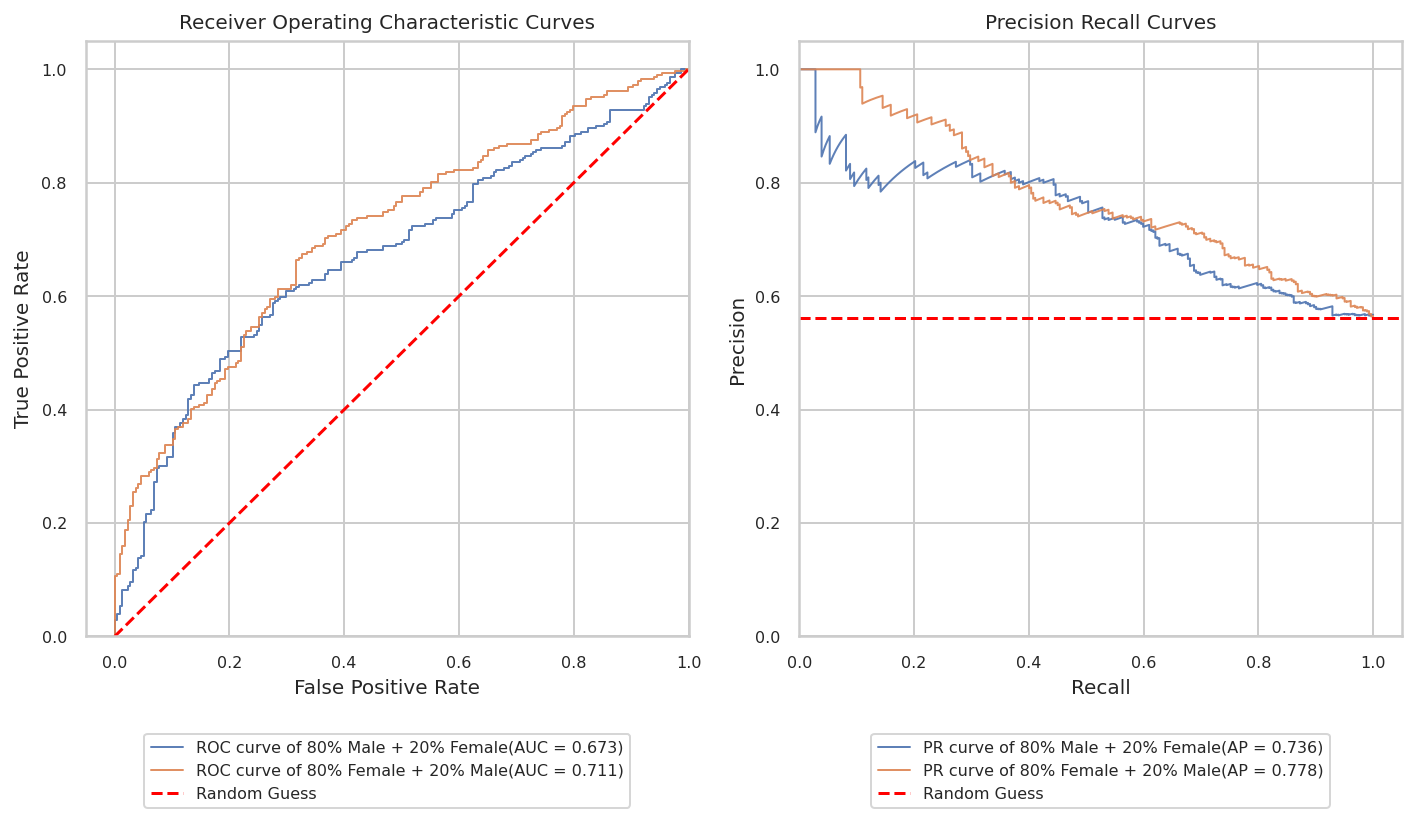

In [120]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 1*2
fig, axs = plt.subplots(1, 2, figsize=(10,6))

# ROC curves
for i in range(len(models)):
    k = models[i]
    axs[0].plot(
          fpr_dict[k],
          tpr_dict[k],
          label="ROC curve of {}(AUC = {:.3f})".format(k, auc_dict[k]),
          lw = 1,
          alpha = 0.9
    )

# PR curves
# reference line
axs[0].plot([0, 1], [0, 1],
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[0].set_title("Receiver Operating Characteristic Curves", fontsize = 10)

axs[0].set_xlabel("False Positive Rate", fontsize = 10)
axs[0].set_ylabel("True Positive Rate", fontsize = 10)

axs[0].set_xlim(-0.05, 1)
axs[0].set_ylim(0, 1.05)

# PR curve for each model
for i in range(len(models)):
    k = models[i]
    axs[1].plot(
            rc_dict[k],
            pc_dict[k],
            label="PR curve of {}(AP = {:.3f})".format(k, ap_dict[k]),
            lw = 1,
            alpha = 0.9
    )


# reference line
axs[1].axhline(y = np.sum(y_val) / len(y_val),
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[1].set_title("Precision Recall Curves", fontsize = 10)

axs[1].set_xlabel("Recall", fontsize = 10)
axs[1].set_ylabel("Precision", fontsize = 10)

axs[1].set_xlim(0, 1.05)
axs[1].set_ylim(0, 1.05)

for j in range(2):
    axs[j].tick_params(labelsize=8)
        
    legend = axs[j].legend(prop={'size': 8},
                           loc="upper center", bbox_to_anchor=(0.5, -0.15))

# use tight layout to save space
plt.tight_layout()

plt.show()